<a href="https://colab.research.google.com/github/ChristianConchari/Computer-Vision-Notes/blob/master/Tutorial_13_Image_Compression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 13: Image Compression Model

So far, you studied how to process, filter, transform, describe, and recognise images from a classical computer vision perspective. Image compression complements all these processing stages by optimising the size of images. This is not only useful for faster computation but also for storage and transmission. In summary, there are two types of image or video compression: lossy and lossless. In the latter compression, the decompressed image is an exact copy of the original image, while in the former compression, the original and the decompressed image differ from each other. Lossless compression is needed when every pixel matters (e.g. in medical data), however, lossy compression is quite useful in images with real-life scenes, where there is plenty of redundancy. 

In this tutorial, you will learn different lossy  compression methods that will help you deal with future big image datasets. 

## 1. Loading an image, and importing resources.

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shape: (1200, 1600)


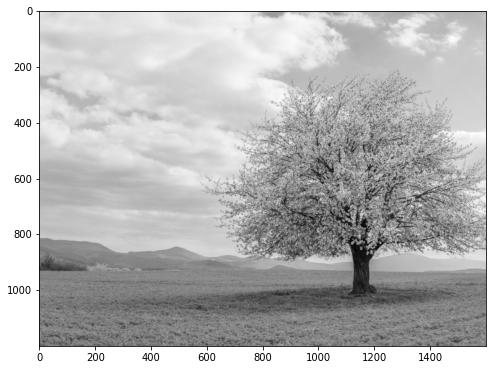

In [ ]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import os, requests
import numpy as np

img_data = requests.get("https://www.gardeningknowhow.com/wp-content/uploads/2020/12/lonely-japanese-cherry.jpg" , verify=False).content
with open('11209579_431786763660187_2553976445473050475_n.jpg', 'wb') as handler:
    handler.write(img_data)

# Load the image
image = cv2.imread('11209579_431786763660187_2553976445473050475_n.jpg')

# Convert the image to gray Scale
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print("Shape:", grayscale.shape)

plt.figure(figsize=(8,8))
plt.imshow(grayscale, cmap="gray")

## 2. Fast Fourier Transform for Image Compression (Lossy)


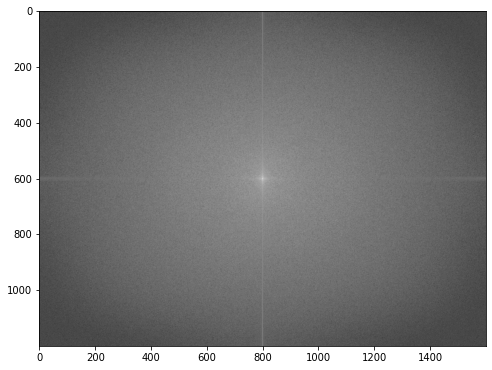

In [ ]:
# Apply Fourier Transform 
fourier = np.fft.fft2(grayscale)

# Bring the center to the middle
fshift = np.fft.fftshift(fourier)

# Scale magnitude values
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.figure(figsize=(8,8))
plt.imshow(magnitude_spectrum, cmap='gray')


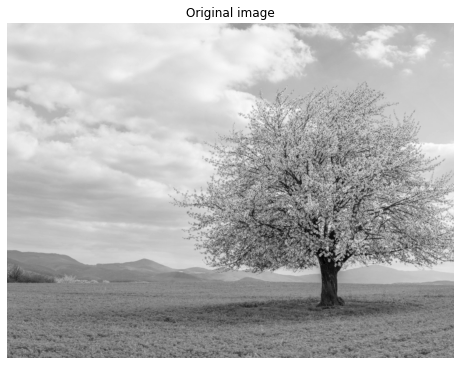

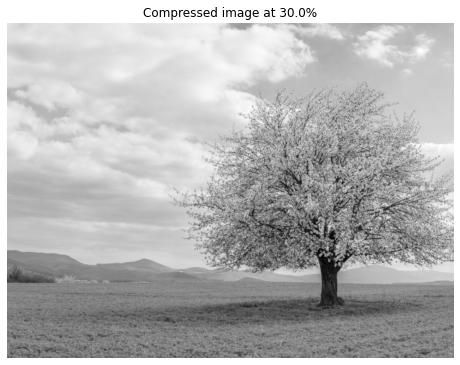

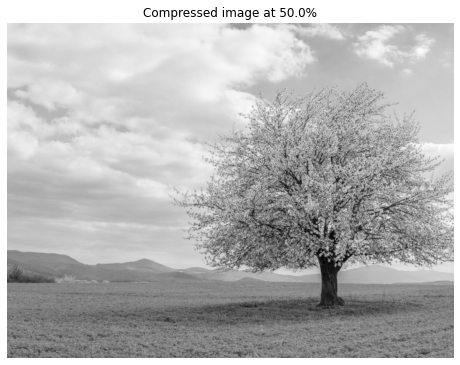

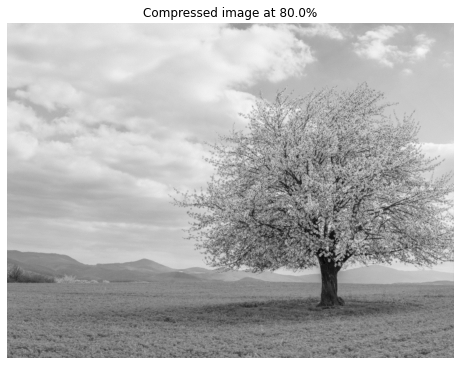

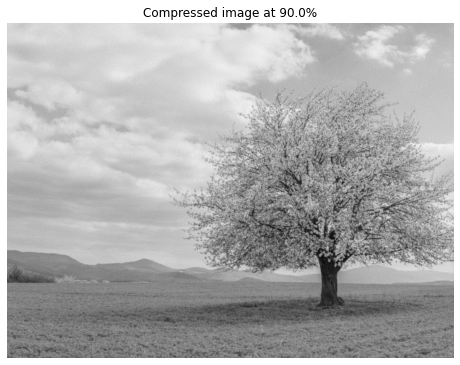

In [ ]:
# Show original image
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(grayscale, cmap="gray")
plt.title("Original image")

# Convert the magntude spectrum into a vector and sort fourier values by magnitude
sorted_fourier = np.sort(np.abs(fourier.reshape(-1)))

#print("Sorted fourier", sorted_fourier)

compression_percentages = [0.3,0.5,0.8,0.9]
dft_images = []

# Apply a threshold by assigning zero to all small coefficients according to the percentage
for percentage in compression_percentages: 
  # Find a threshold value according to the compression percentage
  threshold = sorted_fourier[int(np.floor(percentage*len(sorted_fourier)))]
  # Find smaller values than the threshold. Mark those values as 0 and bigger values as 1. 
  mask = np.abs(fourier)>threshold
  # Remove smaller values in the magnitude spectrum
  masked_image = fourier * mask

  compressed_image = np.fft.ifft2(masked_image).real
  dft_images.append(compressed_image)

  plt.figure(figsize=(8,8))
  plt.imshow(compressed_image, cmap="gray")
  plt.axis("off")
  plt.title("Compressed image at "+str(percentage*100)+"%")


## 2. Discrete Cosine Transform (JPEG - Lossy)

In this section, you'll simulate JPEG compression. Although OpenCV has an DCT implementation, Scipy library's fftpack module has proven to be also efficient with this transform. DCT is an extension of the Fourier Transform that is better suited to the compression of real-valued signals. Let's prove DCT in the entire image first. 

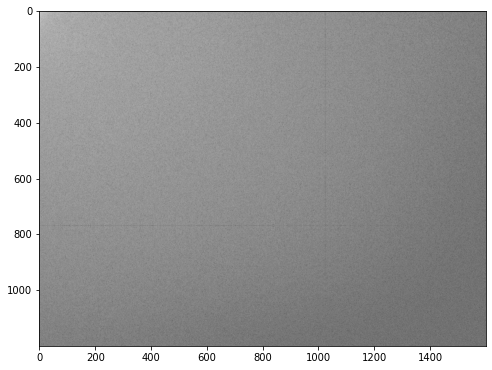

In [ ]:
from scipy import fftpack

# Apply DCT twice for the image (2nd dimension)
dct = np.transpose(fftpack.dct(np.transpose(fftpack.dct(grayscale, norm = "ortho")), norm = "ortho"))

# Scale magnitude values and display
dct = 20*np.log(np.abs(dct))

plt.figure(figsize=(8,8))
plt.imshow(dct, cmap="gray")

Similarl to the FFT2, the low frequencies are now gathered in the upper-left corner, while the other high frequencies are in the opposite side. In practice, the JPEG format relies on small Discrete Cosine Transforms, computed on local square patches of size 8x8, therefore, let's divide the image and apply dct to every patch. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


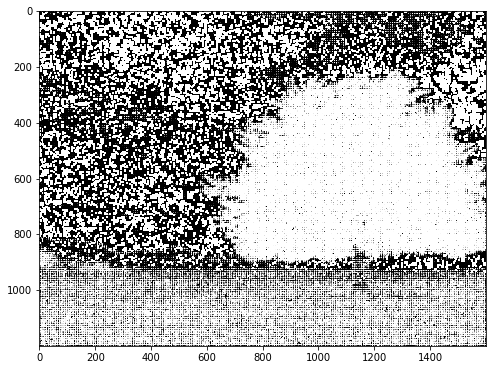

In [ ]:
# Initialize base image  
dct = np.zeros(grayscale.shape)

# Loop over small patches (8x8)
for row in range(1,grayscale.shape[0]//8+1):
  for col in range(1,grayscale.shape[1]//8+1):
    aux = grayscale[(row-1)*8: row*8, (col-1)*8: col*8]
    dct[(row-1)*8: row*8, (col-1)*8: col*8] = np.transpose(fftpack.dct(np.transpose(fftpack.dct(aux, norm = "ortho")), norm = "ortho"))

# Scale magnitude values and display
dct_vis = 20*np.log(np.abs(dct))

plt.figure(figsize=(8,8))
plt.imshow(dct_vis, cmap="gray", vmin=-7, vmax=15)

# Exercise 1: 
The current exercise is to implement the next stepts of  the Discrete Cosine Transform for image compression. Finally you will have to evaluate DCT against FFT2. 

Will be used the non-zeros percentage as a metric for compression.

In [ ]:
# Obtain the image size for processing
imsize = grayscale.shape
# Calculate the nonzeros percentaje for the compressed DCT transforms
percent_nonzeros_dct = np.sum( dct != 0.0 ) / (imsize[0]*imsize[1]*1.0)
print(f'For the non-compressed image we have a {percent_nonzeros_dct*100}% percentage fo non-zeros')

For the non-compressed image we have a 97.88557291666666% percentage fo non-zeros


As we can see in the previous cell, for the only DCT proccesed image we have a non-zeros percentage, which almost represent the 100%.

<Figure size 432x288 with 0 Axes>

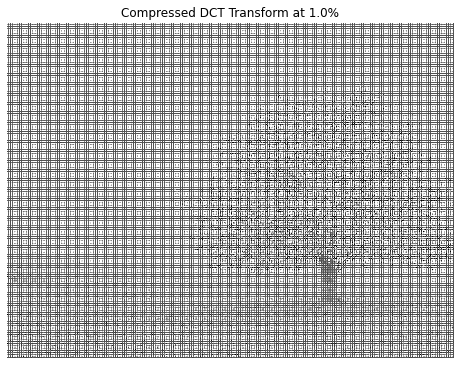

<Figure size 432x288 with 0 Axes>

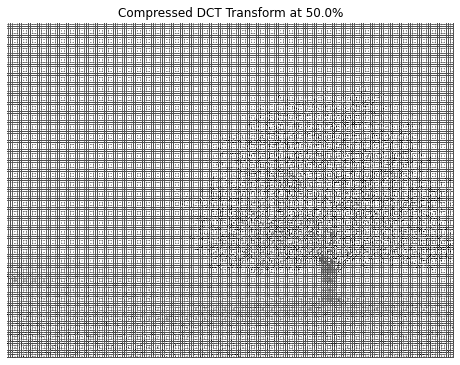

<Figure size 432x288 with 0 Axes>

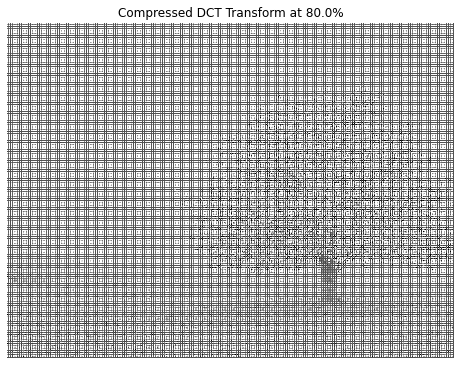

<Figure size 432x288 with 0 Axes>

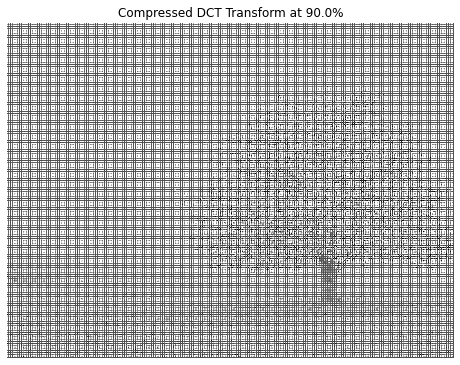

In [ ]:
from numpy import r_

# Apply compression percentages
compression_percentages = [0.01,0.5,0.8,0.9]

# Sort the DCT transform from minor to mayor
sorted_dct = np.sort(np.abs(dct.reshape(-1)))

# Define a list to append the thresh values
dct_thresh_list = []
# Loop all the thresh values
for percentage in compression_percentages:
  threshold = sorted_dct[int(np.floor(percentage*len(sorted_dct)))]
  mask = np.abs(dct) > threshold
  dct_thresh = mask * dct
  dct_thresh_list.append(dct_thresh)
  
  #Plot resulting images
  plt.figure()
  plt.figure(figsize=(8,8))
  plt.imshow(dct_thresh,cmap='gray',vmin=-7, vmax=15)
  plt.axis("off")
  plt.title("Compressed DCT Transform at "+str(percentage*100)+"%")

At first sight, observing the images obtained for different compression percentages, we will not notice very clear changes between images, so we will scale logarithmically the resulting images.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


<Figure size 432x288 with 0 Axes>

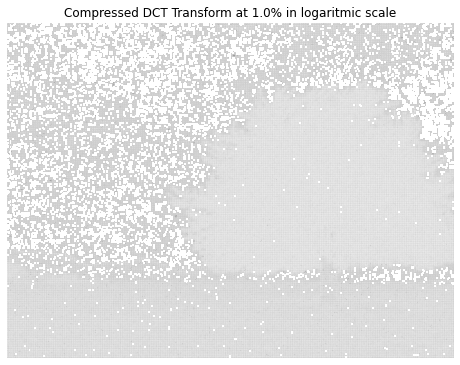

<Figure size 432x288 with 0 Axes>

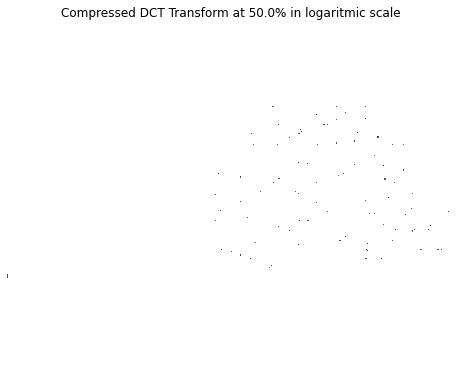

<Figure size 432x288 with 0 Axes>

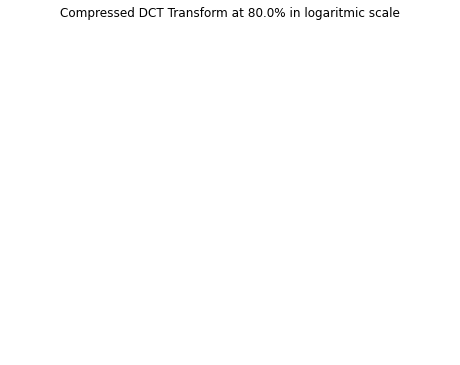

<Figure size 432x288 with 0 Axes>

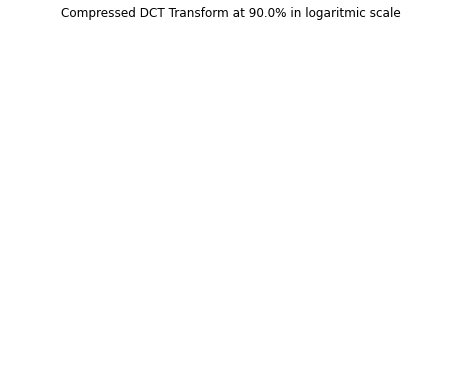

In [ ]:
i=0
for dct_c in dct_thresh_list:
  # Scale magnitude values and display
  dct_vis2 = 20*np.log(np.abs(dct_c))
  percentage = compression_percentages[i]
  i+=1
  #Plot resulting images
  plt.figure()
  plt.figure(figsize=(8,8))
  plt.imshow(dct_vis2,cmap='gray')
  plt.axis("off")
  plt.title("Compressed DCT Transform at "+str(percentage*100)+"% in logaritmic scale")

Now we can notice clearer changes with respect to the DCT without compression, and we can even see how the values of the image degrade until they practically disappear.

Now we will analyze the percentage of post-compression zeros for each compression percentage.

In [ ]:
i=0
for dct_c in dct_thresh_list:
  imsize1 = dct_c.shape
  # Calculate the nonzeros percentaje for the compressed DCT transforms
  percent_nonzeros = np.sum( dct_c != 0.0 ) / (imsize1[0]*imsize1[1]*1.0)
  print(f'For the DCT compressed at {compression_percentages[i]*100}%, we have a {round(percent_nonzeros*100,2)}% percentage fo non-zeros')
  i+=1

For the DCT compressed at 1.0%, we have a 97.89% percentage fo non-zeros
For the DCT compressed at 50.0%, we have a 50.0% percentage fo non-zeros
For the DCT compressed at 80.0%, we have a 20.0% percentage fo non-zeros
For the DCT compressed at 90.0%, we have a 10.0% percentage fo non-zeros


We can see that the percentage of non-zero values decreases as we increase the compression ratio of the image. Note that for this case the percentage of non-zero values is the complement of the compression percentage.

Finally, we will apply inverse DCT to recover a post-compression image.
We will use ```numpy.r_``` module for translate slice objects to concatenation along the first axis (https://numpy.org/doc/stable/reference/generated/numpy.r_.html)

<Figure size 576x576 with 0 Axes>

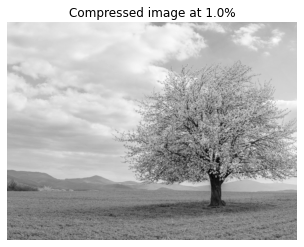

<Figure size 576x576 with 0 Axes>

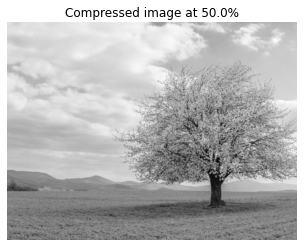

<Figure size 576x576 with 0 Axes>

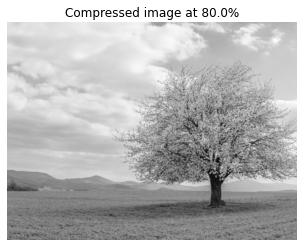

<Figure size 576x576 with 0 Axes>

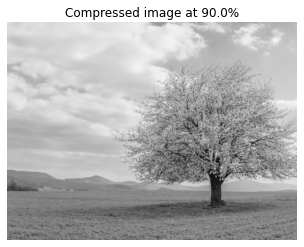

In [ ]:
import scipy
im_dct = np.zeros(imsize)
def idct2(a):
  # Apply inverse DCT 
  return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

dct_images = []

k=0
for dct_c in dct_thresh_list:
  for i in r_[:imsize[0]:8]:
      for j in r_[:imsize[1]:8]:
          im_dct[i:(i+8),j:(j+8)] = idct2( dct_c[i:(i+8),j:(j+8)] )
          dct_images.append(im_dct)

  percentage = compression_percentages[k]
  k+=1        
  plt.figure(figsize=(8,8))       
  plt.figure()
  plt.imshow( im_dct ,cmap='gray')
  plt.axis("off")
  plt.title("Compressed image at "+str(percentage*100)+"%")

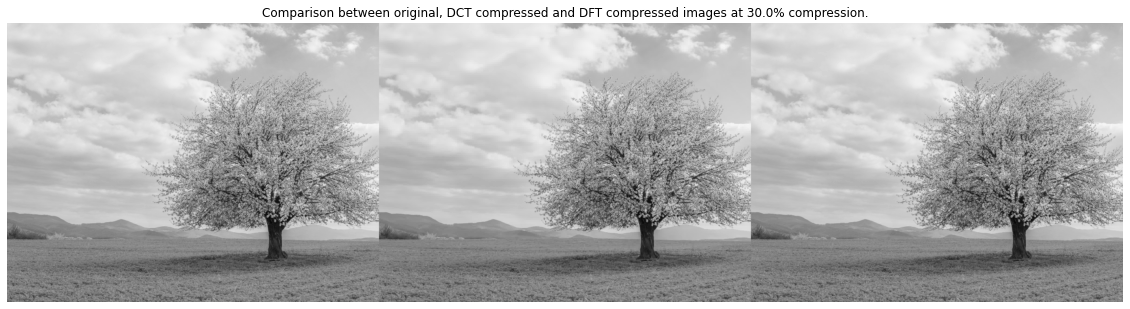

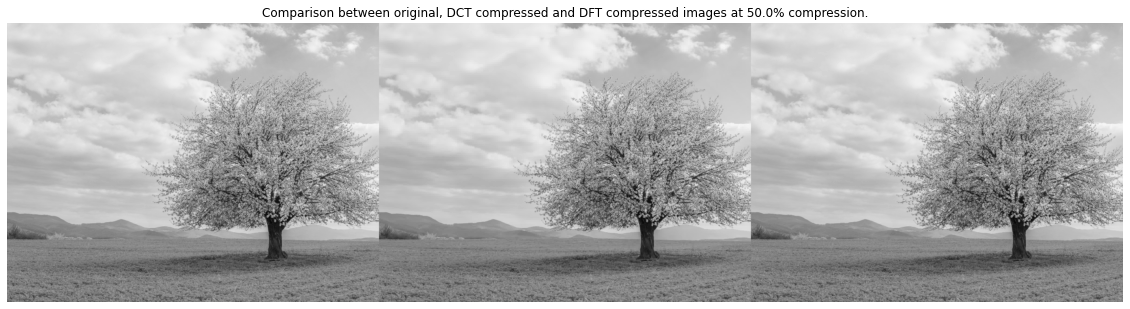

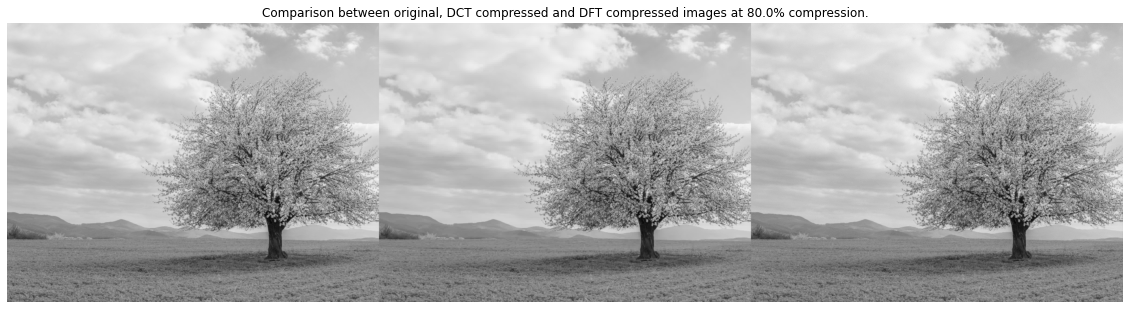

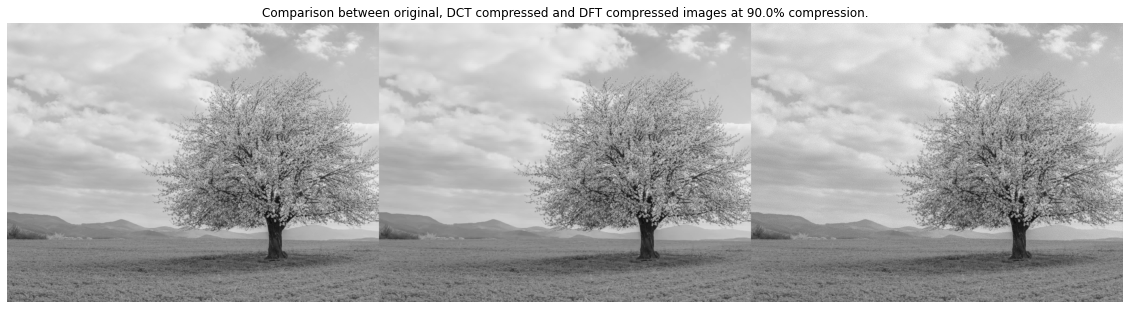

In [ ]:
import os

k=0
for dct_i, dft_i in zip(dct_images, dft_images):
  percentage = compression_percentages[k]
  k+=1
  plt.figure(figsize=(20,20)) 
  plt.imshow( np.hstack( (grayscale, dct_i, dft_i)) ,cmap='gray')
  plt.axis("off")
  plt.title(f"Comparison between original, DCT compressed and DFT compressed images at {percentage*100}% compression." )

As we can see in the images shown in the last cell, as we increase the compression percentage, the quality of the image is reduced in certain areas, where we can see a kind of smoothing or what is known as pixelation. Reviewing some papers about comparissons of these two compression methods, the recently mentioned effect produced by DCT compression is known as blocking, which is the division of the image into 8x8 or larger blocks. As mentioned in the referenced article and as can be seen in the images generated in the cell above, the larger the compression radius, the more visible these blocks become.

This method is more noticeable in the upper part of the images compressed by the DCT method, although it is almost imperceptible until we reach a compression of 50% where this effect becomes noticeable.

###REFERENCE: 
- Ismaili, Imdad & Khowaja, Sander & Soomro, Waseem. (2013). Image Compression, Comparison between Discrete Cosine Transform and Fast Fourier Transform and the problems associated with DCT. 10.13140/2.1.4873.0401. 